<a href="https://colab.research.google.com/github/sarankumarss166/Early_Prediction_of_Gastric_Cancer_using_Endoscopic_Images/blob/main/inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random

processed_path = '/content/drive/MyDrive/gi-endoscopy-project/classification_dataset'
split_base_path = '/content/drive/MyDrive/gi-endoscopy-project/split'

# Create train, val, test folders
for split in ['train', 'val', 'test']:
  for cls in os.listdir(processed_path):
        os.makedirs(os.path.join(split_base_path, split, cls), exist_ok=True)

# Split data
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

for cls in os.listdir(processed_path):
  cls_path = os.path.join(processed_path, cls)
  images = os.listdir(cls_path)
  random.shuffle(images)

  train_end = int(split_ratio['train'] * len(images))
  val_end = train_end + int(split_ratio['val'] * len(images))

  for i, img in enumerate(images):
    src = os.path.join(cls_path, img)
    if i < train_end:
      dest = os.path.join(split_base_path, 'train', cls, img)
    elif i < val_end:
      dest = os.path.join(split_base_path, 'val', cls, img)
    else:
      dest = os.path.join(split_base_path, 'test', cls, img)

    shutil.copy(src, dest)

print("Dataset split into train/val/test complete!")


Dataset split into train/val/test complete!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths for train/val/test folders
train_dir = '/content/drive/MyDrive/gi-endoscopy-project/split/train'
val_dir = '/content/drive/MyDrive/gi-endoscopy-project/split/val'
test_dir = '/content/drive/MyDrive/gi-endoscopy-project/split/test'

# Image size and batch size
IMG_SIZE = (224, 224)  # standard for most models like ResNet, VGG
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
            rotation_range=20,
                        zoom_range=0.2,
                                        horizontal_flip=True
                                                                        )

# Only rescale for validation and test sets
val_datagen =ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the iterators
train_generator = train_datagen.flow_from_directory(
  train_dir,
      target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
                    class_mode='categorical'
                            )

val_generator = val_datagen.flow_from_directory(
      val_dir,
            target_size=IMG_SIZE,
                    batch_size=BATCH_SIZE,
                              class_mode='categorical'
                                        )

test_generator = test_datagen.flow_from_directory(
    test_dir,
          target_size=IMG_SIZE,
                  batch_size=BATCH_SIZE,
                            class_mode='categorical',
                                        shuffle=False

                                        )

Found 2825 images belonging to 5 classes.
Found 605 images belonging to 5 classes.
Found 606 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# 1️⃣ Build model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)  # 5 classes

model = Model(inputs=base_model.input, outputs=outputs)


# 2 Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
                                          metrics=['accuracy'])

# 3️⃣ Checkpoint to save best model
checkpoint = ModelCheckpoint("/content/drive/MyDrive/gi-endoscopy-project/results2/inceptionv3_best.h5",
                             monitor='val_accuracy', save_best_only=True, mode='max')



# 4️⃣ Train for first 20 epochs
history_30 = model.fit(
    train_generator,
            validation_data=val_generator,
                        epochs=30,
                                        batch_size=32,
                                                            callbacks=[checkpoint]
                                                                                )

# 5️⃣ Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 30 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 30 epochs: {test_loss:.4f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.3594 - loss: 1.7626

89/89 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.3603 - loss: 1.7592 - val_accuracy: 0.6678 - val_loss: 0.9017
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.5898 - loss: 1.0449

89/89 ━━━━━━━━━━━━━━━━━━━━ 77s 866ms/step - accuracy: 0.5899 - loss: 1.0444 - val_accuracy: 0.7603 - val_loss: 0.7246
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6771 - loss: 0.8209

89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 829ms/step - accuracy: 0.6770 - loss: 0.8208 - val_accuracy: 0.7818 - val_loss: 0.6244
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7406 - loss: 0.7223

89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 829ms/step - accuracy: 0.7404 - loss: 0.7223 - val_accuracy: 0.8000 - val_loss: 0.5859
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 814ms/step - accuracy: 0.7438 - loss: 0.6717 - val_accuracy: 0.7983 - val_loss: 0.5732
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.7486 - loss: 0.6604

89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 813ms/step - accuracy: 0.7487 - loss: 0.6600 - val_accuracy: 0.8149 - val_loss: 0.5480
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 814ms/step - accuracy: 0.7505 - loss: 0.6375 - val_accuracy: 0.8116 - val_loss: 0.5391
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.7888 - loss: 0.5483

89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 827ms/step - accuracy: 0.7888 - loss: 0.5484 - val_accuracy: 0.8281 - val_loss: 0.5083
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 828ms/step - accuracy: 0.8022 - loss: 0.5209 - val_accuracy: 0.8182 - val_loss: 0.5091
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 817ms/step - accuracy: 0.8012 - loss: 0.5138 - val_accuracy: 0.8281 - val_loss: 0.4891
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 840ms/step - accuracy: 0.8062 - loss: 0.4850 - val_accuracy: 0.8264 - val_loss: 0.5035
Epoch 12/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 831ms/step - accuracy: 0.8147 - loss: 0.4776 - val_accuracy: 0.8281 - val_loss: 0.5139
Epoch 13/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.7973 - loss: 0.5222

89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 858ms/step - accuracy: 0.7975 - loss: 0.5219 - val_accuracy: 0.8347 - val_loss: 0.4609
Epoch 14/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.8310 - loss: 0.4299

89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 838ms/step - accuracy: 0.8310 - loss: 0.4301 - val_accuracy: 0.8397 - val_loss: 0.4634
Epoch 15/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.8308 - loss: 0.4461

89/89 ━━━━━━━━━━━━━━━━━━━━ 77s 856ms/step - accuracy: 0.8308 - loss: 0.4460 - val_accuracy: 0.8446 - val_loss: 0.4588
Epoch 16/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 844ms/step - accuracy: 0.8383 - loss: 0.4231 - val_accuracy: 0.8331 - val_loss: 0.4603
Epoch 17/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 849ms/step - accuracy: 0.8379 - loss: 0.4291 - val_accuracy: 0.8380 - val_loss: 0.4539
Epoch 18/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 821ms/step - accuracy: 0.8277 - loss: 0.4193 - val_accuracy: 0.8413 - val_loss: 0.4420
Epoch 19/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 822ms/step - accuracy: 0.8266 - loss: 0.4316 - val_accuracy: 0.8364 - val_loss: 0.4335
Epoch 20/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 829ms/step - accuracy: 0.8509 - loss: 0.3982 - val_accuracy: 0.8413 - val_loss: 0.4536
Epoch 21/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8497 - loss: 0.3958

89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 850ms/step - accuracy: 0.8497 - loss: 0.3958 - val_accuracy: 0.8463 - val_loss: 0.4390
Epoch 22/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 831ms/step - accuracy: 0.8487 - loss: 0.3963 - val_accuracy: 0.8446 - val_loss: 0.4500
Epoch 23/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 71s 804ms/step - accuracy: 0.8581 - loss: 0.3504 - val_accuracy: 0.8463 - val_loss: 0.4430
Epoch 24/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 856ms/step - accuracy: 0.8548 - loss: 0.3693 - val_accuracy: 0.8364 - val_loss: 0.4444
Epoch 25/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 808ms/step - accuracy: 0.8474 - loss: 0.3998 - val_accuracy: 0.8446 - val_loss: 0.4384
Epoch 26/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.8448 - loss: 0.3816

89/89 ━━━━━━━━━━━━━━━━━━━━ 77s 867ms/step - accuracy: 0.8448 - loss: 0.3815 - val_accuracy: 0.8479 - val_loss: 0.4293
Epoch 27/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8643 - loss: 0.3696

89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 846ms/step - accuracy: 0.8642 - loss: 0.3695 - val_accuracy: 0.8529 - val_loss: 0.4205
Epoch 28/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8575 - loss: 0.3677

89/89 ━━━━━━━━━━━━━━━━━━━━ 84s 866ms/step - accuracy: 0.8575 - loss: 0.3676 - val_accuracy: 0.8545 - val_loss: 0.4149
Epoch 29/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 831ms/step - accuracy: 0.8560 - loss: 0.3673 - val_accuracy: 0.8446 - val_loss: 0.4256
Epoch 30/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 827ms/step - accuracy: 0.8594 - loss: 0.3750 - val_accuracy: 0.8463 - val_loss: 0.4323
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 774ms/step - accuracy: 0.8896 - loss: 0.2893
✅ Test Accuracy after 30 epochs: 85.81%
✅ Test Loss after 30 epochs: 0.3599


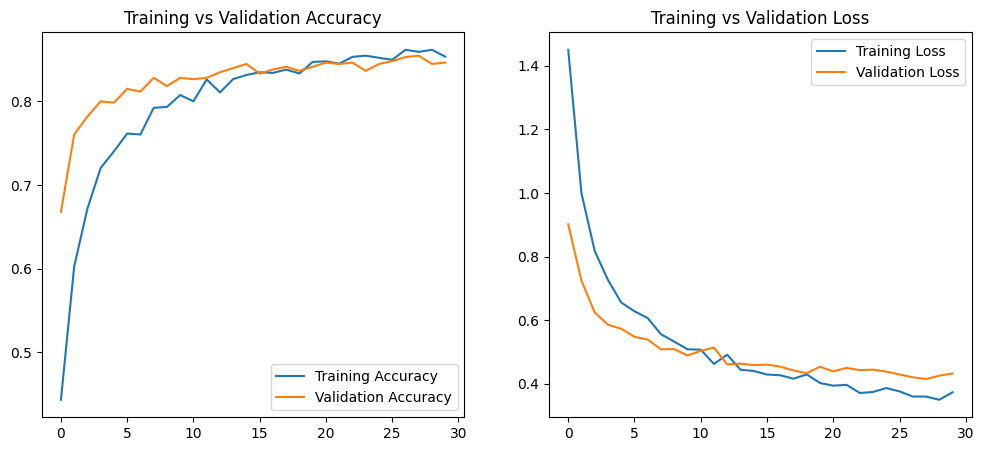

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
acc = history_30.history['accuracy']
val_acc = history_30.history['val_accuracy']
loss = history_30.history['loss']
val_loss = history_30.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))



# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 720ms/step


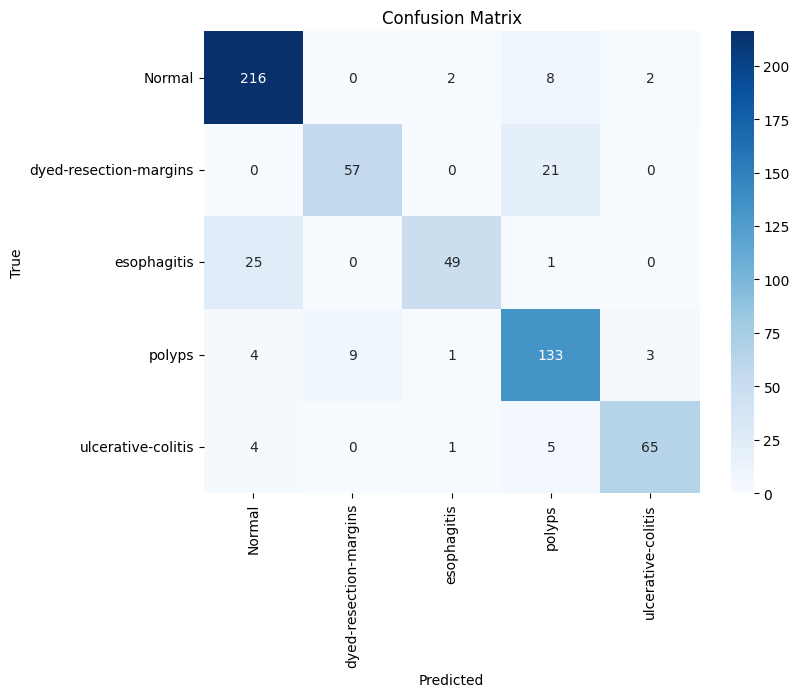

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
                                    yticklabels=test_generator.class_indices.keys())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/tmp/ipython-input-3957373755.py:41: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3957373755.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


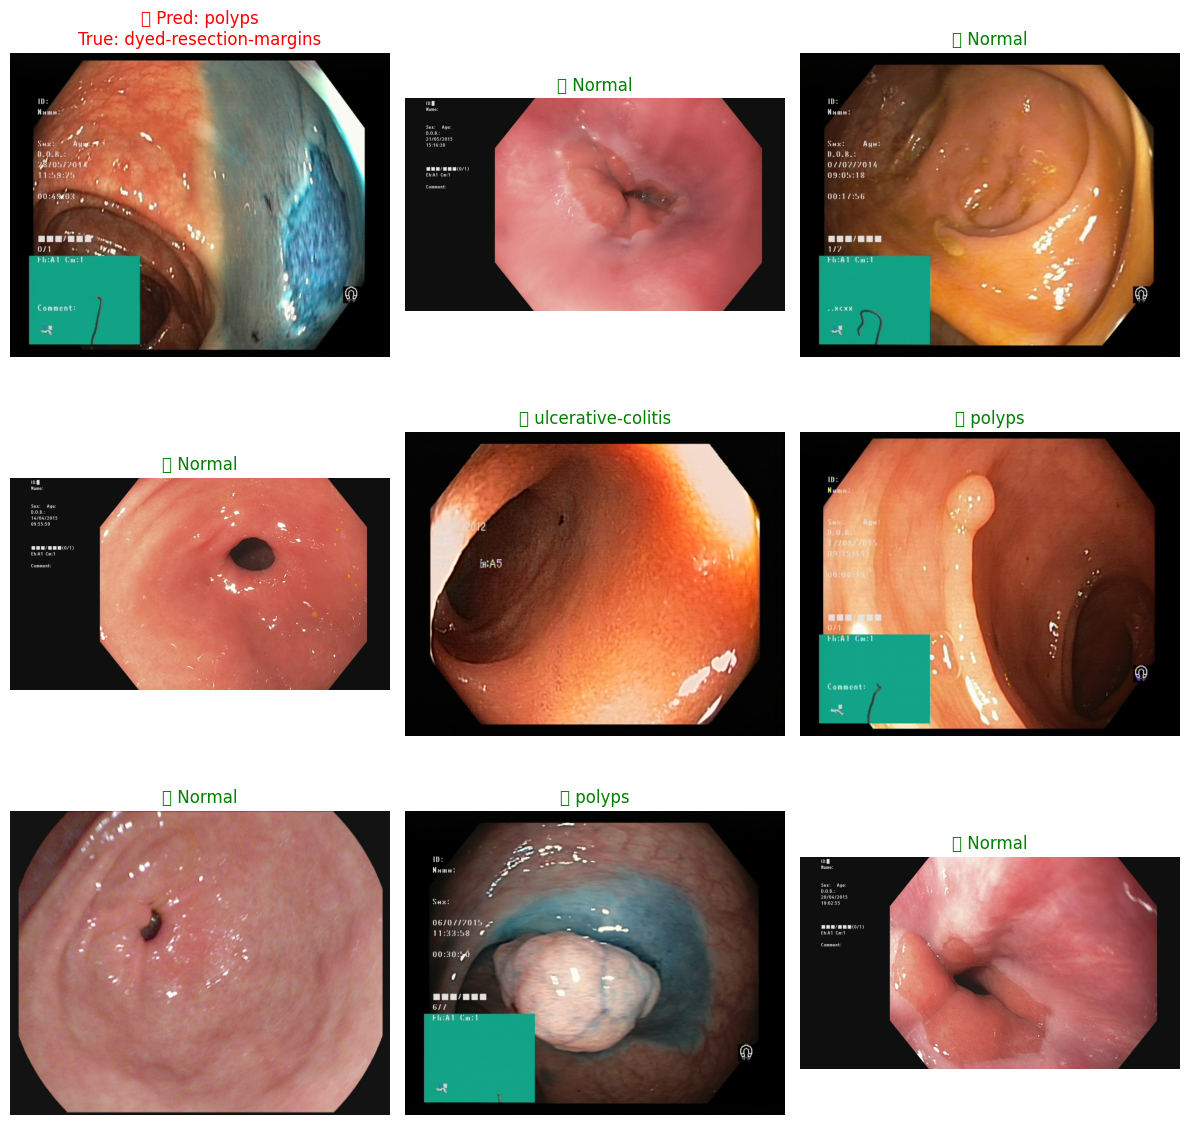

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Pick 9 random test images
plt.figure(figsize=(12, 12))

for i in range(9):
  idx = random.randint(0, len(test_generator.filenames)-1)
  img_path = test_generator.filepaths[idx]

  # True label
  true_class = img_path.split("/")[-2]  # folder name is true label

  # Load and preprocess image
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  # Predict
  pred = model.predict(img_array, verbose=0)
  pred_class = class_labels[np.argmax(pred)]

  # Plot
  plt.subplot(3, 3, i+1)
  plt.imshow(image.load_img(img_path))
  if pred_class == true_class:
    color = "green"
    title = f"✅ {pred_class}"
  else:
    color = "red"
    title = f"❌ Pred: {pred_class}\nTrue: {true_class}"

  plt.title(title, color=color, fontsize=12)
  plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 1️⃣ Checkpoint to save best model again
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/gi-endoscopy-project/results2/inceptionv3_best.h5",
            monitor='val_accuracy',
                        save_best_only=True,
                                        mode='max'
                                                        )


# 2️⃣ Continue training for next 10 epochs (from epoch 30 → 40)
history = model.fit(train_generator,
        validation_data=val_generator,
                                    initial_epoch=30,   # 👈 tells Keras we already trained 30 epochs
                                                                    epochs=40,          # total epochs
                                                                                                        callbacks=[checkpoint]
                                                                                                                                            )
# 3️⃣ Evaluate again on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 40 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 40 epochs: {test_loss:.4f}")


Epoch 31/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8552 - loss: 0.3719

89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 858ms/step - accuracy: 0.8552 - loss: 0.3719 - val_accuracy: 0.8496 - val_loss: 0.4172
Epoch 32/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 853ms/step - accuracy: 0.8652 - loss: 0.3252 - val_accuracy: 0.8380 - val_loss: 0.4349
Epoch 33/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 816ms/step - accuracy: 0.8692 - loss: 0.3423 - val_accuracy: 0.8463 - val_loss: 0.4221
Epoch 34/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 814ms/step - accuracy: 0.8803 - loss: 0.3091 - val_accuracy: 0.8446 - val_loss: 0.4094
Epoch 35/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 824ms/step - accuracy: 0.8743 - loss: 0.3242 - val_accuracy: 0.8496 - val_loss: 0.4244
Epoch 36/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.8898 - loss: 0.3078

89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 841ms/step - accuracy: 0.8897 - loss: 0.3081 - val_accuracy: 0.8512 - val_loss: 0.4320
Epoch 37/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 829ms/step - accuracy: 0.8674 - loss: 0.3313 - val_accuracy: 0.8463 - val_loss: 0.4263
Epoch 38/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 810ms/step - accuracy: 0.8726 - loss: 0.3189 - val_accuracy: 0.8446 - val_loss: 0.4334
Epoch 39/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 815ms/step - accuracy: 0.8791 - loss: 0.3059 - val_accuracy: 0.8397 - val_loss: 0.4301
Epoch 40/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 816ms/step - accuracy: 0.8825 - loss: 0.3110 - val_accuracy: 0.8430 - val_loss: 0.4186
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.8970 - loss: 0.2690
✅ Test Accuracy after 40 epochs: 85.97%
✅ Test Loss after 40 epochs: 0.3477


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 1️⃣ Checkpoint to save best model again
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/gi-endoscopy-project/results2/inceptionv3_best.h5",
                monitor='val_accuracy',
                                        save_best_only=True,
                                                                                mode='max'
                                                                                                                                        )


history_more = model.fit(
                      train_generator,  epochs=50,   # since you already trained till 40
                    initial_epoch=40,   # resume from 40
                                                                                                          validation_data=val_generator, callbacks=[checkpoint] )

# 🎯 Evaluate after 50 epochs
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 50 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 50 epochs: {test_loss:.4f}")

Epoch 41/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.8702 - loss: 0.3250

89/89 ━━━━━━━━━━━━━━━━━━━━ 77s 869ms/step - accuracy: 0.8703 - loss: 0.3249 - val_accuracy: 0.8380 - val_loss: 0.4338
Epoch 42/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.8733 - loss: 0.3150

89/89 ━━━━━━━━━━━━━━━━━━━━ 78s 880ms/step - accuracy: 0.8734 - loss: 0.3148 - val_accuracy: 0.8463 - val_loss: 0.4223
Epoch 43/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 884ms/step - accuracy: 0.8858 - loss: 0.2741 - val_accuracy: 0.8446 - val_loss: 0.4115
Epoch 44/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 890ms/step - accuracy: 0.8832 - loss: 0.3009 - val_accuracy: 0.8463 - val_loss: 0.4256
Epoch 45/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 922ms/step - accuracy: 0.8878 - loss: 0.3020 - val_accuracy: 0.8364 - val_loss: 0.4359
Epoch 46/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 843ms/step - accuracy: 0.8934 - loss: 0.2666 - val_accuracy: 0.8463 - val_loss: 0.4191
Epoch 47/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 80s 818ms/step - accuracy: 0.8891 - loss: 0.2921 - val_accuracy: 0.8413 - val_loss: 0.4342
Epoch 48/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 810ms/step - accuracy: 0.8943 - loss: 0.2708 - val_accuracy: 0.8413 - val_loss: 0.4351
Epoch 49/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 72s 810ms/step - accuracy: 0.8933 - loss: 0.2620 - val_accuracy

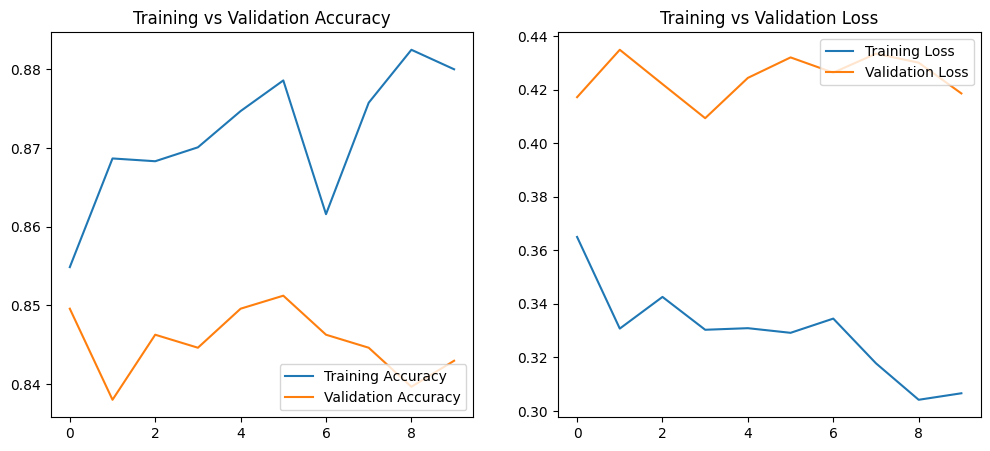

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step


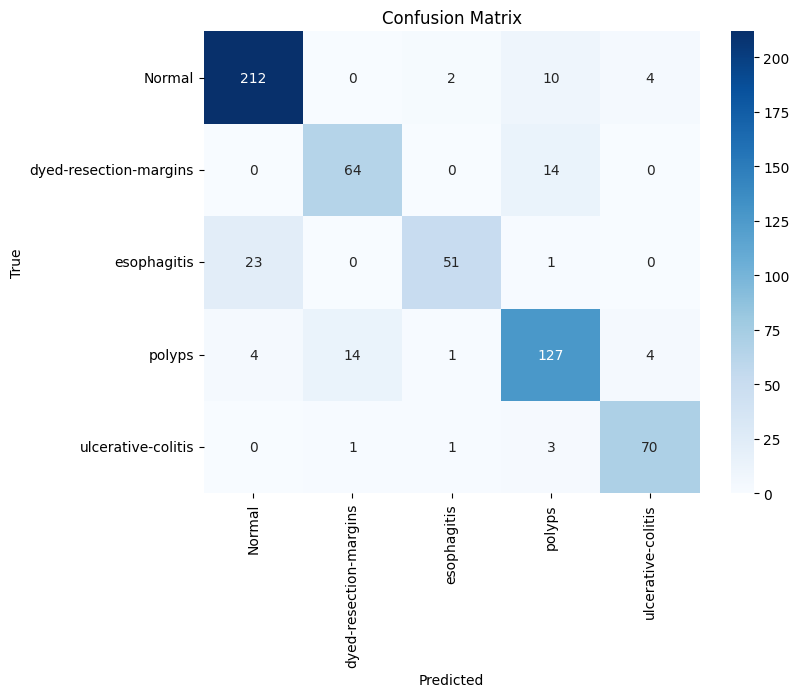

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
                                                yticklabels=test_generator.class_indices.keys())


plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/tmp/ipython-input-3508263108.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3508263108.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


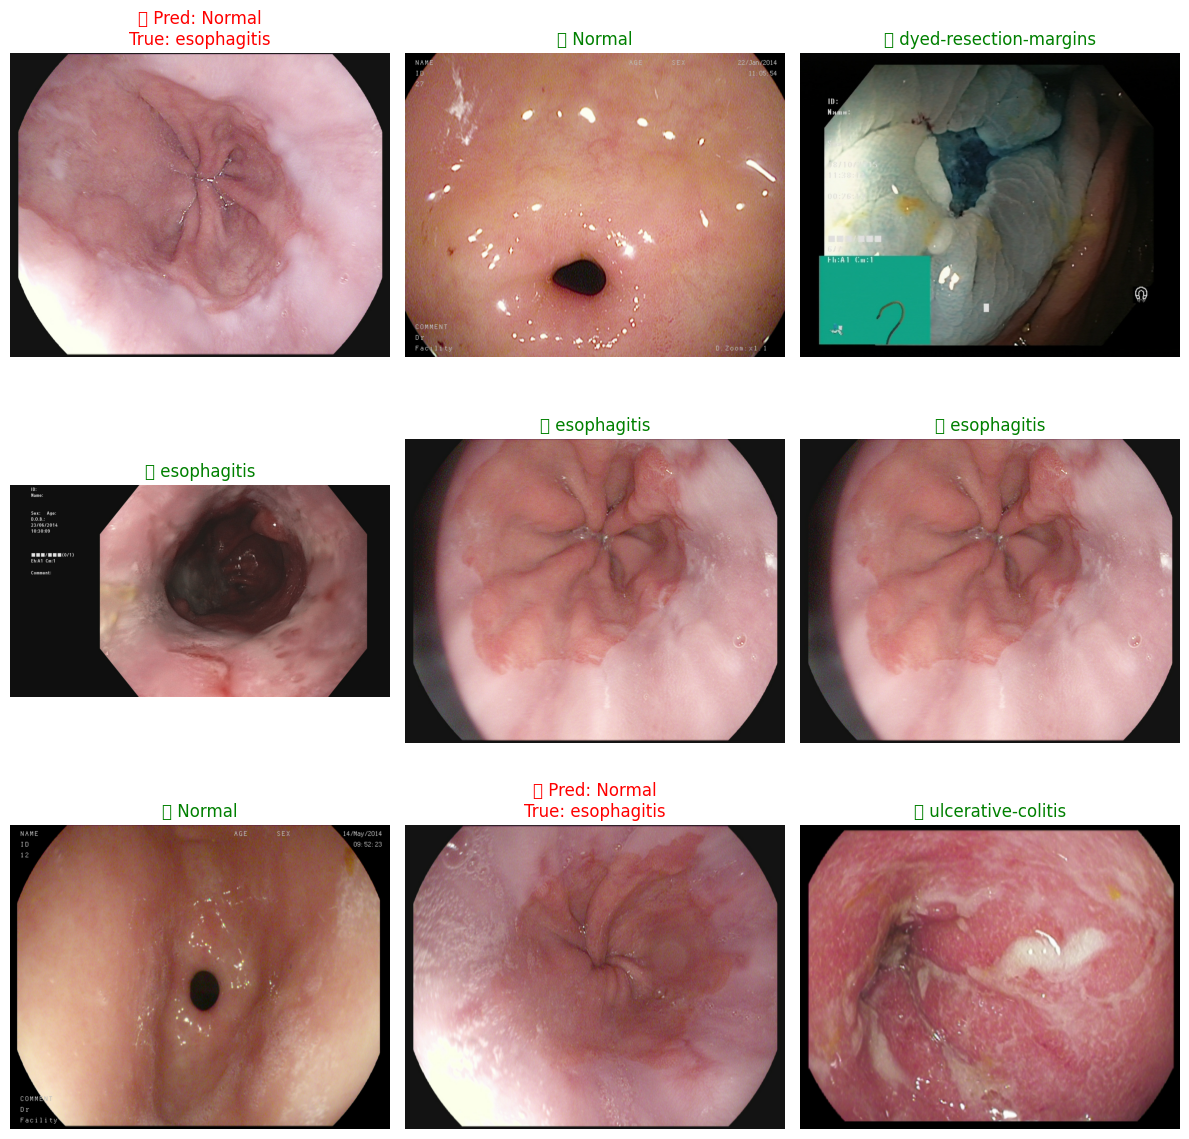

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Pick 9 random test images
plt.figure(figsize=(12, 12))

for i in range(9):
  idx = random.randint(0, len(test_generator.filenames)-1)
  img_path = test_generator.filepaths[idx]

  # True label
  true_class = img_path.split("/")[-2]  # folder name is true label

  # Load and preprocess image
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  # Predict
  pred = model.predict(img_array, verbose=0)
  pred_class = class_labels[np.argmax(pred)]

  # Plot
  plt.subplot(3, 3, i+1)
  plt.imshow(image.load_img(img_path))
  if pred_class == true_class:
    color = "green"
    title = f"✅ {pred_class}"
  else:
    color = "red"
    title = f"❌ Pred: {pred_class}\nTrue: {true_class}"
  plt.title(title, color=color, fontsize=12)
  plt.axis("off")

plt.tight_layout()
plt.show()

